# Evaluación de Modelos - Solar Power Prediction

Análisis de rendimiento de modelos Dual-Stream y Tri-Stream entrenados.

In [ ]:
# Configuración
ID_PLANTA = 305  # Cambiar según planta: 239, 309, 346
IN_STEPS = 11   # Ventana histórica (horas)
OUT_STEPS = 48  # Horizonte predicción (horas)

# Setup
import sys
from pathlib import Path
BASE_DIR = Path.cwd().parent
sys.path.insert(0, str(BASE_DIR))

from src.config import get_plant_config
plant_config = get_plant_config(ID_PLANTA)
FECHA_INICIO = plant_config['fecha_inicio']
FECHA_FIN = plant_config['fecha_fin']

MODEL_NAME = f'Nuevodual_stream_lstm_cnn_{ID_PLANTA}_{IN_STEPS}h_{OUT_STEPS}h.keras'
#MODEL_NAME = f'tri_stream_gating_{ID_PLANTA}_{IN_STEPS}h_{OUT_STEPS}h.keras'  # Alternativa

print(f"✅ Planta {ID_PLANTA} | {plant_config['nombre']} ({plant_config['potencia_mw']} MW)")
print(f"📊 Modelo: {MODEL_NAME}")

✅ Planta 305 | Las Terrazas (2.99 MW)
📊 Modelo: tri_stream_gating_305_11h_48h.keras


In [28]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

from src.models.windowing_utils import create_dual_stream_data

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')
plt.rcParams['figure.figsize'] = (16, 6)

## 1. Cargar Modelo y Datos

In [29]:
# Rutas
MODEL_PATH = BASE_DIR / 'models' / MODEL_NAME
DATA_PATH = BASE_DIR / 'data' / '03_processed' / f'DatosCombinados_{FECHA_INICIO}_a_{FECHA_FIN}_Planta{ID_PLANTA}.csv'

# Verificar
if not MODEL_PATH.exists():
    print(f"❌ Modelo no encontrado: {MODEL_PATH}")
if not DATA_PATH.exists():
    print(f"❌ Datos no encontrados: {DATA_PATH}")

In [30]:
model = keras.models.load_model(MODEL_PATH)
print(f"✅ Modelo cargado: {MODEL_NAME}")

✅ Modelo cargado: tri_stream_gating_305_11h_48h.keras


In [31]:
df = pd.read_csv(DATA_PATH, index_col=0, parse_dates=True)
print(f"✅ Datos: {len(df):,} registros | {df.index[0]} a {df.index[-1]}")

✅ Datos: 8,761 registros | 2014-10-30 00:00:00 a 2015-10-30 00:00:00


In [32]:
# Detectar arquitectura
input_shape_past = model.input[0].shape
expected_features = input_shape_past[2]

if expected_features == 15:
    from src.models.windowing_utils import get_default_feature_sets
    TARGET_COLUMN, FUTURE_FEATURES, PAST_FEATURES = get_default_feature_sets()
    FEATURE_CONFIG = 'reducido_feriado'
elif expected_features == 14:
    TARGET_COLUMN = 'gen_normalizada'
    FUTURE_FEATURES = ['glb', 'dni', 'dif', 'temp', 'vel', 'shadow', 'cloud',
                       'hora_sin', 'hora_cos', 'mes_sin', 'mes_cos', 'dia_año_sin', 'dia_año_cos']
    PAST_FEATURES = [TARGET_COLUMN] + FUTURE_FEATURES
    FEATURE_CONFIG = 'reducido'
elif expected_features == 19:
    TARGET_COLUMN = 'gen_normalizada'
    FUTURE_FEATURES = ['glb', 'dir', 'dif', 'sct', 'ghi', 'dirh', 'difh', 'dni',
                       'temp', 'vel', 'shadow', 'cloud',
                       'hora_sin', 'hora_cos', 'mes_sin', 'mes_cos', 'dia_año_sin', 'dia_año_cos']
    PAST_FEATURES = [TARGET_COLUMN] + FUTURE_FEATURES
    FEATURE_CONFIG = 'completo'
else:
    raise ValueError(f"Arquitectura no reconocida: {expected_features} features")

print(f"✅ Configuración: {FEATURE_CONFIG.upper()} ({expected_features} features)")

✅ Configuración: REDUCIDO (14 features)


## 2. Preparar Datos (División Cronológica sin Solapamiento)

In [33]:
# Splits con gaps
total_timesteps = len(df)
window_size = IN_STEPS + OUT_STEPS

train_end_idx = int(total_timesteps * 0.70)
val_start_idx = train_end_idx + (window_size - 1)
val_end_idx = int(total_timesteps * 0.85)
test_start_idx = val_end_idx + (window_size - 1)

df_train = df.iloc[:train_end_idx]
df_val = df.iloc[val_start_idx:val_end_idx]
df_test = df.iloc[test_start_idx:]

# Detectar tipo
num_model_inputs = len(model.input) if isinstance(model.input, list) else 1
IS_TRI_STREAM = (num_model_inputs == 3)

# Crear ventanas
if IS_TRI_STREAM:
    from src.models.windowing_utils import create_tri_stream_data_alternativo
    binary_features = ['feriado'] if 'feriado' in df.columns else ['cloud']
    
    X_past_train, X_future_train, X_binary_train, Y_train = create_tri_stream_data_alternativo(
        df_train, n_past=IN_STEPS, n_future=OUT_STEPS, binary_features=binary_features,
        feature_sets=(TARGET_COLUMN, FUTURE_FEATURES, PAST_FEATURES))
    X_past_val, X_future_val, X_binary_val, Y_val = create_tri_stream_data_alternativo(
        df_val, n_past=IN_STEPS, n_future=OUT_STEPS, binary_features=binary_features,
        feature_sets=(TARGET_COLUMN, FUTURE_FEATURES, PAST_FEATURES))
    X_past_test, X_future_test, X_binary_test, Y_test = create_tri_stream_data_alternativo(
        df_test, n_past=IN_STEPS, n_future=OUT_STEPS, binary_features=binary_features,
        feature_sets=(TARGET_COLUMN, FUTURE_FEATURES, PAST_FEATURES))
    
    print(f"✅ TRI-STREAM: Test={X_past_test.shape[0]} muestras")
else:
    X_past_train, X_future_train, Y_train = create_dual_stream_data(
        df_train, n_past=IN_STEPS, n_future=OUT_STEPS,
        feature_sets=(TARGET_COLUMN, FUTURE_FEATURES, PAST_FEATURES))
    X_past_val, X_future_val, Y_val = create_dual_stream_data(
        df_val, n_past=IN_STEPS, n_future=OUT_STEPS,
        feature_sets=(TARGET_COLUMN, FUTURE_FEATURES, PAST_FEATURES))
    X_past_test, X_future_test, Y_test = create_dual_stream_data(
        df_test, n_past=IN_STEPS, n_future=OUT_STEPS,
        feature_sets=(TARGET_COLUMN, FUTURE_FEATURES, PAST_FEATURES))
    
    print(f"✅ DUAL-STREAM: Test={X_past_test.shape[0]} muestras")

✅ TRI-STREAM: Test=1199 muestras


## 3. Predicciones y Métricas

In [34]:
# Predicciones
if IS_TRI_STREAM:
    Y_pred = model.predict([X_past_test, X_future_test, X_binary_test], verbose=0)
else:
    Y_pred = model.predict([X_past_test, X_future_test], verbose=0)

print(f"✅ Predicciones: {Y_pred.shape}")

✅ Predicciones: (1199, 48)


In [35]:
# Cargar historial
history_filename = MODEL_NAME.replace('.keras', '_history.csv')
HISTORY_PATH = BASE_DIR / 'figures' / history_filename
SUMMARY_PATH = BASE_DIR / 'figures' / 'training_summary.csv'

if HISTORY_PATH.exists():
    history_df = pd.read_csv(HISTORY_PATH)
    best_val_mae = history_df['val_mae'].min()
    
    if SUMMARY_PATH.exists():
        summary_df = pd.read_csv(SUMMARY_PATH)
        model_summary = summary_df[summary_df['model_name'] == MODEL_NAME]
        if not model_summary.empty:
            training_time = model_summary['total_time_minutes'].values[0]
            print(f"⏱️ Entrenamiento: {len(history_df)} épocas, {training_time:.1f} min")
else:
    history_df = None
    print("⚠️ Historial no encontrado")

⏱️ Entrenamiento: 17 épocas, 0.8 min


In [36]:
# Métricas Test
mae = np.mean(np.abs(Y_test - Y_pred))
mse = np.mean((Y_test - Y_pred) ** 2)
rmse = np.sqrt(mse)

print(f"\n📊 TEST METRICS")
print(f"   MAE:  {mae:.6f} ({mae*100:.2f}%)")
print(f"   RMSE: {rmse:.6f} ({rmse*100:.2f}%)")


📊 TEST METRICS
   MAE:  0.054630 (5.46%)
   RMSE: 0.098497 (9.85%)


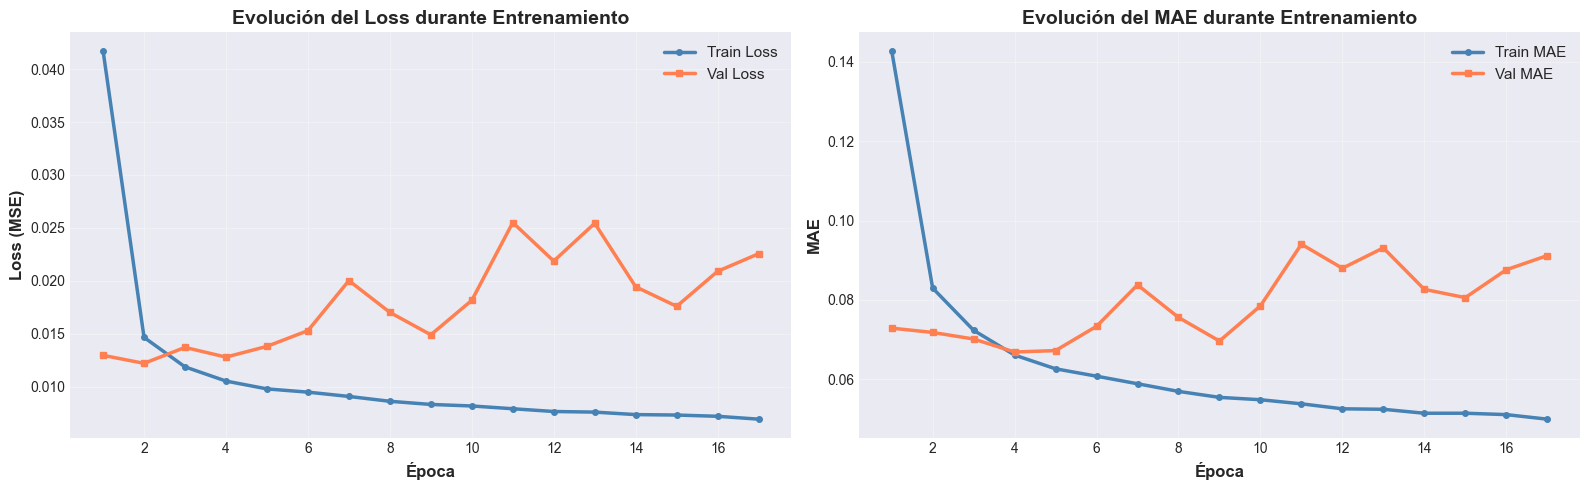

In [37]:
if history_df is not None:
    fig, axes = plt.subplots(1, 2, figsize=(16, 5))
    
    # Loss
    axes[0].plot(history_df['epoch'], history_df['loss'], label='Train Loss', 
                 linewidth=2.5, marker='o', markersize=4, color='steelblue')
    axes[0].plot(history_df['epoch'], history_df['val_loss'], label='Val Loss', 
                 linewidth=2.5, marker='s', markersize=4, color='coral')
    axes[0].set_xlabel('Época', fontsize=12, fontweight='bold')
    axes[0].set_ylabel('Loss (MSE)', fontsize=12, fontweight='bold')
    axes[0].set_title('Evolución del Loss durante Entrenamiento', fontsize=14, fontweight='bold')
    axes[0].legend(fontsize=11)
    axes[0].grid(True, alpha=0.3)
    
    # MAE
    axes[1].plot(history_df['epoch'], history_df['mae'], label='Train MAE', 
                 linewidth=2.5, marker='o', markersize=4, color='steelblue')
    axes[1].plot(history_df['epoch'], history_df['val_mae'], label='Val MAE', 
                 linewidth=2.5, marker='s', markersize=4, color='coral')
    axes[1].set_xlabel('Época', fontsize=12, fontweight='bold')
    axes[1].set_ylabel('MAE', fontsize=12, fontweight='bold')
    axes[1].set_title('Evolución del MAE durante Entrenamiento', fontsize=14, fontweight='bold')
    axes[1].legend(fontsize=11)
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
else:
    print("⚠️  No se puede graficar: historial no encontrado")

## 5. Predicciones vs Real (Horizonte 48h)

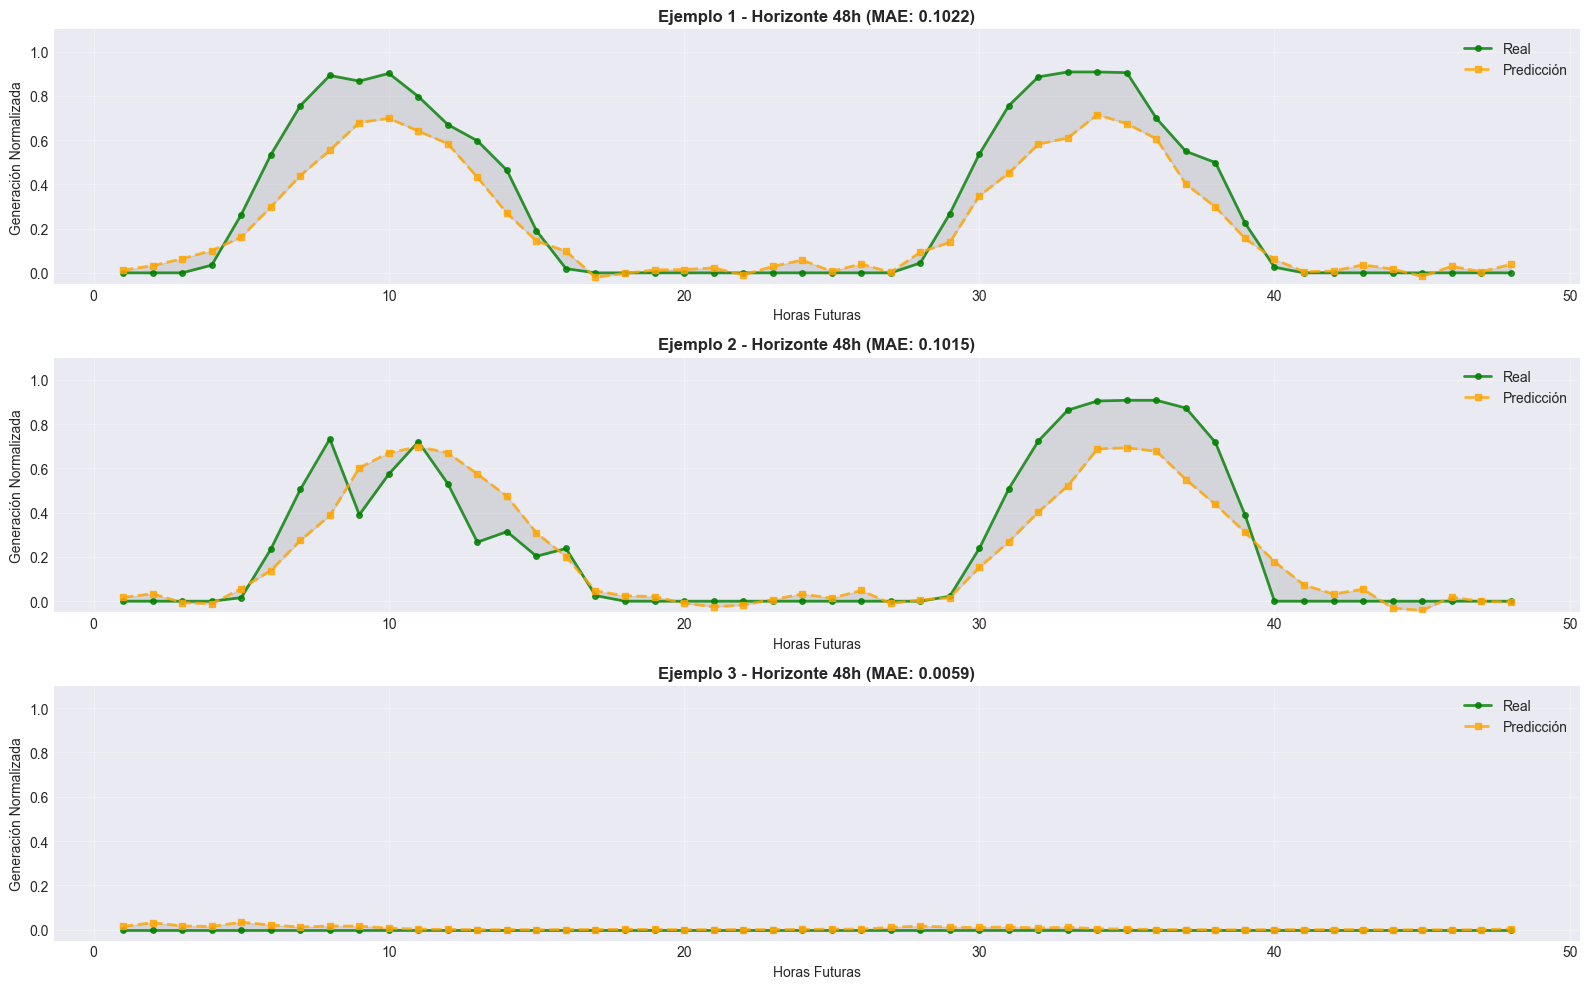

In [38]:
# 3 ejemplos aleatorios
np.random.seed(42)
sample_indices = np.random.choice(len(Y_test), size=3, replace=False)

fig, axes = plt.subplots(3, 1, figsize=(16, 10))

for i, idx in enumerate(sample_indices):
    real = Y_test[idx]
    pred = Y_pred[idx]
    mae_sample = np.mean(np.abs(real - pred))
    
    axes[i].plot(range(1, OUT_STEPS+1), real, 'o-', linewidth=2, markersize=4, 
                 label='Real', color='green', alpha=0.8)
    axes[i].plot(range(1, OUT_STEPS+1), pred, 's--', linewidth=2, markersize=4, 
                 label='Predicción', color='orange', alpha=0.8)
    axes[i].fill_between(range(1, OUT_STEPS+1), real, pred, alpha=0.2, color='gray')
    
    axes[i].set_title(f'Ejemplo {i+1} - Horizonte 48h (MAE: {mae_sample:.4f})', 
                     fontsize=12, fontweight='bold')
    axes[i].set_xlabel('Horas Futuras')
    axes[i].set_ylabel('Generación Normalizada')
    axes[i].legend()
    axes[i].grid(True, alpha=0.3)
    axes[i].set_ylim(-0.05, 1.1)

plt.tight_layout()
plt.show()

## 6. Distribución del Error (Residuales)

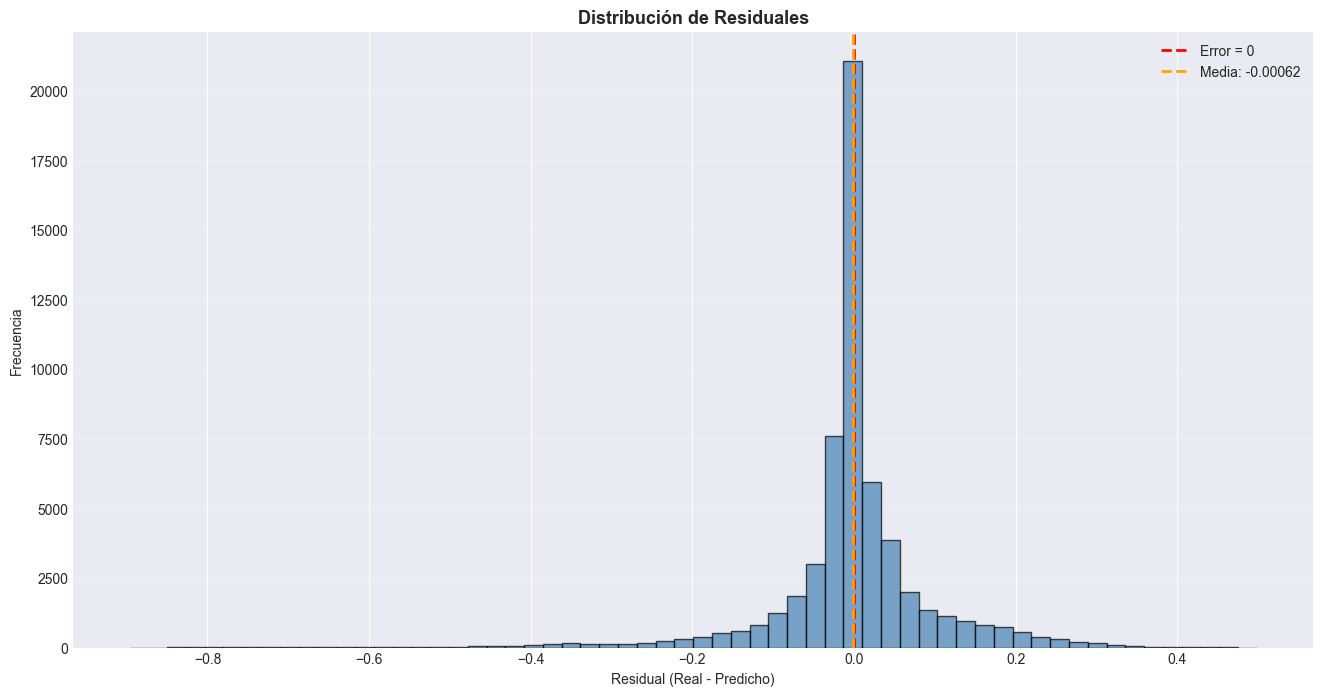


📊 Residuales: μ=-0.00062, σ=0.09849


In [39]:
# Residuales
residuals = (Y_test - Y_pred).flatten()

fig, axes = plt.subplots(figsize=(16, 8))

# Histograma
axes.hist(residuals, bins=60, color='steelblue', alpha=0.7, edgecolor='black')
axes.axvline(x=0, color='red', linestyle='--', linewidth=2, label='Error = 0')
axes.axvline(x=np.mean(residuals), color='orange', linestyle='--', linewidth=2, 
                label=f'Media: {np.mean(residuals):.5f}')
axes.set_xlabel('Residual (Real - Predicho)')
axes.set_ylabel('Frecuencia')
axes.set_title('Distribución de Residuales', fontsize=13, fontweight='bold')
axes.legend()
axes.grid(True, alpha=0.3, axis='y')

plt.show()

print(f"\n📊 Residuales: μ={np.mean(residuals):.5f}, σ={np.std(residuals):.5f}")